### Building a Model To predict Emails Open Rates (OR%) , Based on the following Features 
- Time ( month of the year , quarter of the year , day of the week )
- Pirority of email , main or reminder 
- Category ( interval , final )
- Number of emails sent in each subject
- Constructed Features
 - Length of the subject 
 - Personalization of Email
 - Having emoji or not
 - Casual tone or formal 
 - Urgency at the subject 
 - Metion of price or discount in the subject 
 - Imperative tone in the subject 
 - Mention of product in the subject

In [22]:
#importing libraries 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
#r reading the data as a dataframe
df = pd.read_csv("model_data.csv")

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sent date          1279 non-null   object 
 1   Q                  1279 non-null   object 
 2   DD                 1279 non-null   object 
 3   Category name      1279 non-null   object 
 4   Main vs REM        1279 non-null   object 
 5   Subject            1279 non-null   object 
 6   Sendings           1279 non-null   int64  
 7   OR clean %         1279 non-null   float64
 8   CTR clean %        1279 non-null   float64
 9   Date               1279 non-null   object 
 10  Month              1279 non-null   int64  
 11  translation        1279 non-null   object 
 12  length of subject  1279 non-null   int64  
 13  Personalization    1279 non-null   int64  
 14  Emoji              1279 non-null   int64  
 15  Urgency            1279 non-null   int64  
 16  Tone               1279 

In [25]:
columns_to_drop = [ "Subject", "CTR clean %","translation","Sent date","Date"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

- I droped  ( "Subject", " Translation") because each  is a sentence has no predictive value in this model 
- I droped  ("CTR%") because it will have an affect of data leakage 
- I droped ("Date") because I already has features for ("Month"),("DD")

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Q                  1279 non-null   object 
 1   DD                 1279 non-null   object 
 2   Category name      1279 non-null   object 
 3   Main vs REM        1279 non-null   object 
 4   Sendings           1279 non-null   int64  
 5   OR clean %         1279 non-null   float64
 6   Month              1279 non-null   int64  
 7   length of subject  1279 non-null   int64  
 8   Personalization    1279 non-null   int64  
 9   Emoji              1279 non-null   int64  
 10  Urgency            1279 non-null   int64  
 11  Tone               1279 non-null   int64  
 12  Price or Discount  1279 non-null   int64  
 13  imperative         1279 non-null   int64  
 14  product            1279 non-null   int64  
dtypes: float64(1), int64(10), object(4)
memory usage: 150.0+ KB


- Confirming that Data is valid for regression models 
 - Cheking correlation 
 - Ckeking multicoliniarity

In [27]:
# code to check correlation 
target = "OR clean %"  

numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_with_target = numeric_df.corr()[target].sort_values(ascending=False)

print("\n✅ Correlation with target:")
print(corr_with_target)


✅ Correlation with target:
OR clean %           1.000000
product              0.083323
length of subject    0.029782
Personalization     -0.088820
Emoji               -0.110824
Tone                -0.174803
Price or Discount   -0.177772
imperative          -0.291674
Month               -0.326971
Urgency             -0.351497
Sendings            -0.383908
Name: OR clean %, dtype: float64


In [28]:
# code to check multicolinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = numeric_df.drop(columns=[target])  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n✅ VIF to detect multicollinearity:")
print(vif_data)


✅ VIF to detect multicollinearity:
             feature       VIF
0           Sendings  1.504852
1              Month  4.392172
2  length of subject  1.194921
3    Personalization  1.139873
4              Emoji  2.720514
5            Urgency  2.016956
6               Tone  4.851942
7  Price or Discount  4.317476
8        imperative   2.557880
9            product  3.858880


The previous result shows that there is no multicolinearity effect 


In [29]:
def detect_outliers_in_column_table(df, col):
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame.")
    
    Q1 = df[col].quantile(0.10)
    Q3 = df[col].quantile(0.90)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].copy()
    
    # Optional: Add a column showing the outlier value clearly
    outliers['outlier_value'] = outliers[col]
    
    return outliers

In [30]:
outliers_OR = detect_outliers_in_column_table(df, "OR clean %")
display(outliers_OR)  

,Q,DD,Category name,Main vs REM,Sendings,OR clean %,Month,length of subject,Personalization,Emoji,Urgency,Tone,Price or Discount,imperative,product,outlier_value
108,Q1,Wednesday,NL Interval,MAIN,300,0.32,3,0,0,0,0,0,0,0,1,0.32


In [31]:
df = df.drop(outliers_OR.index)

### Building a simple linear regression model 

In [32]:
# building the model X and Y 
target_column = "OR clean %" 
X = df.drop(columns=[target_column])
y = df[target_column]

In [33]:
# finding categorical columns which has to be encoded later 
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [34]:
# deciding numerical columns 
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [35]:
# the preprocessor will onehotencode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

In [36]:
#deviding the data to training set and test set 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [37]:
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

In [38]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Q', 'DD', 'Category name',
                                                   'Main vs REM'])])),
                ('regressor', LinearRegression())])

In [39]:
y_pred = model.predict(X_test)

In [40]:
print("✅ Model Performance:")
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

✅ Model Performance:
R² Score: 0.3991300276740618
MSE: 0.0008277484734656761


The previous linear regression model predictive power is very weak , so i will build another tree model 

### Building a random forest regressor model 


In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

model2 = model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R² Score: 0.7558323734630437
MSE: 0.0003363612585820313


### Searching hyperparameter space to improve Randomforest Regressor Model



In [42]:
X = pd.get_dummies(X, drop_first=True)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [44]:
rf = RandomForestRegressor(random_state=42)

# ⚡ Reduced hyperparameter grid for fast tuning
param_grid = {
    'n_estimators': [100, 200],       # fewer options
    'max_depth': [5, 10, None],       # small grid
    'min_samples_split': [2, 5],      # small grid
    'min_samples_leaf': [1, 2],       # small grid
    'max_features': ['sqrt', 0.8]     # only 2 options
}

# Grid search with 3-fold CV instead of 5
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid,
    cv=3, n_jobs=-1, scoring='r2'
)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predict
y_pred = best_rf.predict(X_test)

# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("\n✅ Best Hyperparameters Found:")
print(grid_search.best_params_)

R² Score: 0.7795912662711313
MSE: 0.0003036314032740658

✅ Best Hyperparameters Found:
{'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


Creating a chart for the most important features 

             feature  importance
0           Sendings    0.637289
1              Month    0.104436
5            Urgency    0.069388
8        imperative     0.032497
7  Price or Discount    0.030252


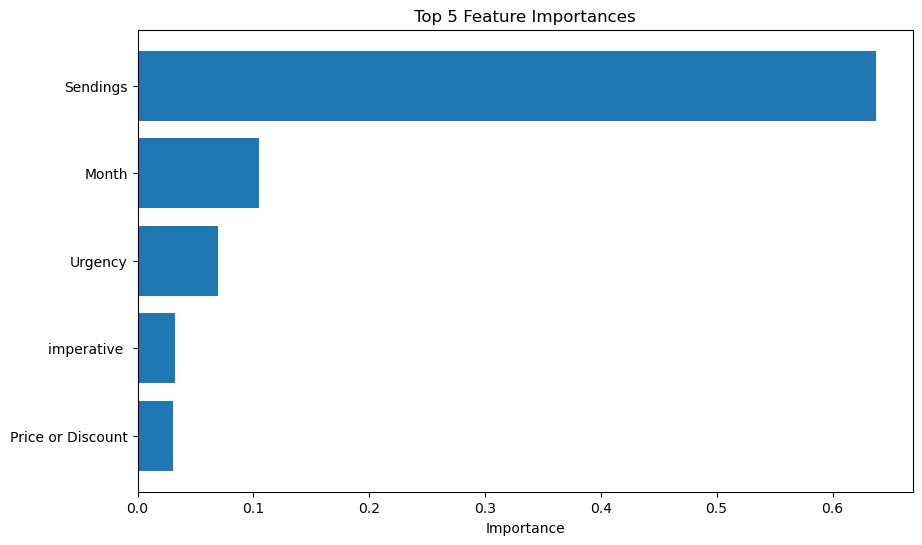

In [45]:

import matplotlib.pyplot as plt

# Assuming `best_rf` is your trained RandomForestRegressor
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances.head(5))

# Optional: Plot
top5_features = feature_importances.head(5)

# Plot
plt.figure(figsize=(10,6))
plt.barh(top5_features['feature'], top5_features['importance'])
plt.xlabel("Importance")
plt.title("Top 5 Feature Importances")
plt.gca().invert_yaxis()
plt.show()


### Future improvment 
- I believe that having more historical data ( more than one year ) , will result in improving the accuracy of the model 
- testing more complicated models ( logistic regression / neuron network ), could result in building a better model in terms of predictions 
- Trying wider hyperparameters space will result in finding a better model , but this step needs more computational power 